In [1]:
import pandas as pd
import numpy as np

In [2]:
busy_file = r"E:\machin-prj\congestion\data\혼잡도 최종등급_통합.csv"
region = r"E:\machin-prj\congestion\data\지역기반관광정보조회 데이터_시도+시군구+법정동+행정동 추가.csv"

df_busy = pd.read_csv(busy_file, encoding= "cp949")
df_region = pd.read_csv(region, encoding='utf-8-sig')

df_busy

,시도,시군구,읍면동,시간대,혼잡도,z_score,min_max,fixed_level,quantile_level,final_level
0,경기도,가평군,가평읍,00시,408.375000,-0.290630,0.311725,보통,여유,여유
1,경기도,가평군,가평읍,01시,112.416667,-0.084662,0.498607,보통,보통,보통
2,경기도,가평군,가평읍,02시,66.208333,0.218280,0.677755,붐빔,붐빔,붐빔
3,경기도,가평군,가평읍,03시,6.916667,0.070654,0.661022,붐빔,붐빔,붐빔
4,경기도,가평군,가평읍,04시,-94.708333,0.247461,0.735938,붐빔,붐빔,붐빔
...,...,...,...,...,...,...,...,...,...,...
30931,인천광역시,중구,해안동3가,19시,22.041667,-0.182652,0.643921,보통,붐빔,붐빔
30932,인천광역시,중구,해안동3가,20시,43.750000,-0.034822,0.742341,보통,붐빔,붐빔
30933,인천광역시,중구,해안동3가,21시,-20.083333,-0.012757,0.770124,보통,매우 붐빔,붐빔
30934,인천광역시,중구,해안동3가,22시,14.500000,-0.078088,0.738980,보통,붐빔,붐빔


In [ ]:
import time
import requests
import pandas as pd
from tqdm import tqdm
from typing import Optional, Tuple

# 1) API 설정
API_KEY = "0be64775eb0d51574480225b2b175243"
URL           = "https://dapi.kakao.com/v2/local/search/address.json"
HEADERS       = {"Authorization": f"KakaoAK {API_KEY}"}
SLEEP_SEC     = 0.11    # 초당 10건 제한 대응

# 2) 행정동 → 위경도 변환 함수
def geocode(addr: str) -> Tuple[Optional[float], Optional[float]]:
    """
    행정동 주소(addr)를 입력받아 (lat, lon)을 반환.
    실패 시 (None, None) 리턴.
    """
    try:
        res = requests.get(URL, headers=HEADERS, params={"query": addr}, timeout=5)
        res.raise_for_status()
        docs = res.json().get("documents")
        if docs:
            return float(docs[0]["y"]), float(docs[0]["x"])
    except requests.RequestException:
        pass
    return None, None


# 4) geocode 함수 적용
lats, lons = [], []
for dong in tqdm(df_busy["읍면동"], desc="Geocoding"):
    lat, lon = geocode(dong)
    lats.append(lat)
    lons.append(lon)
    time.sleep(SLEEP_SEC)

df_busy["latitude"]  = lats
df_busy["longitude"] = lons

df_busy


Geocoding:   0%|          | 0/30936 [00:00<?, ?it/s]

Geocoding: 100%|██████████| 30936/30936 [1:48:51<00:00,  4.74it/s]  


,시도,시군구,읍면동,시간대,혼잡도,z_score,min_max,fixed_level,quantile_level,final_level,latitude,longitude
0,경기도,가평군,가평읍,00시,408.375000,-0.290630,0.311725,보통,여유,여유,37.825364,127.516539
1,경기도,가평군,가평읍,01시,112.416667,-0.084662,0.498607,보통,보통,보통,37.825364,127.516539
2,경기도,가평군,가평읍,02시,66.208333,0.218280,0.677755,붐빔,붐빔,붐빔,37.825364,127.516539
3,경기도,가평군,가평읍,03시,6.916667,0.070654,0.661022,붐빔,붐빔,붐빔,37.825364,127.516539
4,경기도,가평군,가평읍,04시,-94.708333,0.247461,0.735938,붐빔,붐빔,붐빔,37.825364,127.516539
...,...,...,...,...,...,...,...,...,...,...,...,...
30931,인천광역시,중구,해안동3가,19시,22.041667,-0.182652,0.643921,보통,붐빔,붐빔,37.471410,126.622168
30932,인천광역시,중구,해안동3가,20시,43.750000,-0.034822,0.742341,보통,붐빔,붐빔,37.471410,126.622168
30933,인천광역시,중구,해안동3가,21시,-20.083333,-0.012757,0.770124,보통,매우 붐빔,붐빔,37.471410,126.622168
30934,인천광역시,중구,해안동3가,22시,14.500000,-0.078088,0.738980,보통,붐빔,붐빔,37.471410,126.622168


In [6]:
import pymysql
import pandas as pd
from sqlalchemy import create_engine

# MySQL 연결 정보 설정
host = 'localhost'         # 호스트 (예: '127.0.0.1')
user = 'root'              # 사용자 이름
password = '0000'      # 사용자 비밀번호
database = 'df_region'       # 데이터베이스 이름

# MySQL 연결 엔진 생성
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}/{database}")

# # 데이터 저장 (엑셀 및 CSV)
df_busy.to_sql('busy_table', con=engine, if_exists='replace', index=False)

# print("데이터가 성공적으로 MySQL에 저장되었습니다!")


30936

In [7]:
table_busy = 'busy_table'
df_busy = pd.read_sql(table_busy, con=engine)
df_busy

,시도,시군구,읍면동,시간대,혼잡도,z_score,min_max,fixed_level,quantile_level,final_level,latitude,longitude
0,경기도,가평군,가평읍,00시,408.375000,-0.290630,0.311725,보통,여유,여유,37.825364,127.516539
1,경기도,가평군,가평읍,01시,112.416667,-0.084662,0.498607,보통,보통,보통,37.825364,127.516539
2,경기도,가평군,가평읍,02시,66.208333,0.218280,0.677755,붐빔,붐빔,붐빔,37.825364,127.516539
3,경기도,가평군,가평읍,03시,6.916667,0.070654,0.661022,붐빔,붐빔,붐빔,37.825364,127.516539
4,경기도,가평군,가평읍,04시,-94.708333,0.247461,0.735938,붐빔,붐빔,붐빔,37.825364,127.516539
...,...,...,...,...,...,...,...,...,...,...,...,...
30931,인천광역시,중구,해안동3가,19시,22.041667,-0.182652,0.643921,보통,붐빔,붐빔,37.471410,126.622168
30932,인천광역시,중구,해안동3가,20시,43.750000,-0.034822,0.742341,보통,붐빔,붐빔,37.471410,126.622168
30933,인천광역시,중구,해안동3가,21시,-20.083333,-0.012757,0.770124,보통,매우 붐빔,붐빔,37.471410,126.622168
30934,인천광역시,중구,해안동3가,22시,14.500000,-0.078088,0.738980,보통,붐빔,붐빔,37.471410,126.622168


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from math import radians, sin, cos, sqrt, asin

# Haversine 거리 계산 함수
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    return 2 * 6371 * asin(sqrt(a))  # 지구 반지름 6371km

In [21]:
station_lat, station_lon = 37.5561, 126.9726

# 거리 계산 후 가장 가까운 읍면동 찾기
df_busy["거리"] = df_busy.apply(lambda row: haversine(station_lat, station_lon, row["latitude"], row["longitude"]), axis=1)
closest_place = df_busy.loc[df_busy["거리"].idxmin(), "읍면동"]

In [22]:

# 한글 폰트 설정 (Windows 사용자의 경우)
plt.rc('font', family='Malgun Gothic')  # 'Malgun Gothic'은 윈도우 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False  


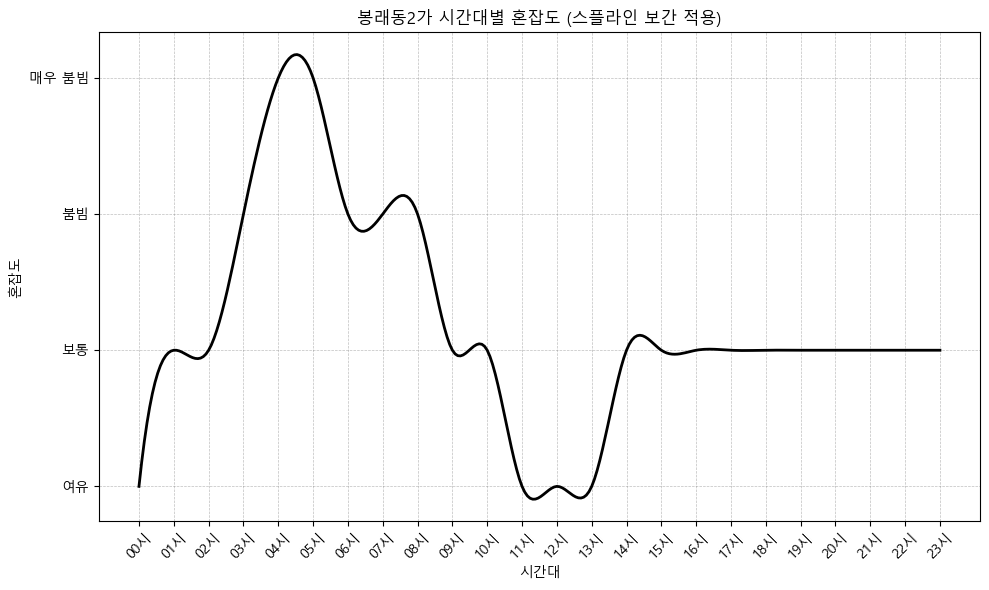

In [30]:
# 가장 가까운 읍면동 찾기
df_busy['distance'] = df_busy.apply(lambda row: haversine(station_lat, station_lon, row['latitude'], row['longitude']), axis=1)
closest_area = df_busy.loc[df_busy['distance'].idxmin(), '읍면동']

# 시간대별 혼잡도 데이터 준비
closest_df = df_busy[df_busy['읍면동'] == closest_area].sort_values(by='시간대')
time_labels = closest_df['시간대'].str.replace('시','').astype(int)

level_map = {'여유': 1, '보통': 2, '붐빔': 3, '매우 붐빔': 4}
levels_numeric = closest_df['final_level'].map(level_map)

# 스플라인 보간으로 부드러운 곡선 생성
x_smooth = np.linspace(time_labels.min(), time_labels.max(), 300)
spl = make_interp_spline(time_labels, levels_numeric, k=3)
y_smooth = spl(x_smooth)

# 라인차트 그리기
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, linestyle='-', linewidth=2, color='black')
plt.xticks(np.arange(0, 24), [f'{i:02d}시' for i in range(24)], rotation=45)
plt.yticks([1, 2, 3, 4], ['여유', '보통', '붐빔', '매우 붐빔'])
plt.title(f'{closest_area} 시간대별 혼잡도 (스플라인 보간 적용)')
plt.xlabel('시간대')
plt.ylabel('혼잡도')
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()

plt.show()